In [1]:
#hide
#default_exp dev.mapgen

# Map Generation

<br>

### Imports

In [2]:
#exports
import json
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import typer
from tqdm import tqdm
from jinja2 import Template

from ElexonDataPortal.dev import utils, raw

<br>

### Power Plant Output Data Retrieval

In [3]:
#hide
# loads the api_key into an environment variable - delete this cell if passing as string
from dotenv import load_dotenv

assert load_dotenv('../.env'), 'Environment variables could not be loaded'
api_key = os.environ['BMRS_API_KEY']

In [4]:
#exports
def construct_df_PN_pivot_dt_rng(df_PN):
    no_seconds = (((df_PN['timeFrom'].str.split(':').str[-1]=='00').mean()==1) & 
                  ((df_PN['timeTo'].str.split(':').str[-1]=='00').mean()==1))

    if no_seconds == True:
        dt_rng = pd.date_range(df_PN['timeFrom'].min(), df_PN['timeTo'].max(), freq='min')
    else:
        dt_rng = pd.date_range(df_PN['timeFrom'].min(), df_PN['timeTo'].max(), freq='s')

    return dt_rng

def construct_PN_pivot_df(df_PN):
    bmu_ids = sorted(list(df_PN['bmUnitID'].unique()))
    df_PN_pivot = pd.DataFrame(index=construct_df_PN_pivot_dt_rng(df_PN), columns=bmu_ids, dtype=float)

    for bmu_id in tqdm(bmu_ids):
        for idx, row in df_PN.query('bmUnitID==@bmu_id').iterrows():
            df_PN_pivot.loc[pd.to_datetime(row['timeFrom']), bmu_id] = float(row['pnLevelFrom'])
            df_PN_pivot.loc[pd.to_datetime(row['timeTo']), bmu_id] = float(row['pnLevelTo'])

        df_PN_pivot[bmu_id] = df_PN_pivot[bmu_id].interpolate()
        
    return df_PN_pivot

def get_latest_PN_df(api_key):
    start_date = pd.Timestamp.now().round('30min') - pd.Timedelta(minutes=30)
    end_date = pd.Timestamp.now().round('30min') + pd.Timedelta(minutes=90)

    df = pd.DataFrame()

    for idx, (date, SP) in tqdm(utils.dt_rng_to_SPs(start_date, end_date).iterrows()):
        df_SP = utils.parse_xml_response(raw.get_PHYBMDATA(api_key, SettlementDate=date, SettlementPeriod=SP, ServiceType='xml'))
        df = df.append(df_SP)
        
    df = (df
          .query('recordType=="PN"')
          .dropna(how='all', axis=1)
          .pipe(construct_PN_pivot_df)
         )

    return df

In [5]:
df_PN = get_latest_PN_df(api_key)

df_PN.index.min(), df_PN.index.max()

3it [01:18, 25.37s/it]c:\users\ayrto\desktop\phd\data\bmrs\elexon-bmrs-api-wrapper\ElexonDataPortal\dev\utils.py:31: UserWarning: Data request was succesful but no content was returned
  warn(f'Data request was succesful but no content was returned')
5it [01:19, 15.92s/it]
100%|█████████████████████████████████████████████████████████████████████████████| 1364/1364 [00:06<00:00, 199.09it/s]


(Timestamp('2021-06-16 15:30:00', freq='T'),
 Timestamp('2021-06-16 17:00:00', freq='T'))

In [6]:
nearest_half_hour = (pd.Timestamp.now()+pd.Timedelta(minutes=15)).round('30min')
most_recent_available_dt = max(df_PN.index[df_PN.index<=nearest_half_hour])

s_PN = df_PN.loc[most_recent_available_dt]

s_PN.replace(0, np.nan).dropna().head()

2__ABGAS000   -371.0
2__ACNDL001     29.0
2__AEELC000   -191.0
2__AEMEB000   -194.0
2__AENRD000   -158.0
Name: 2021-06-16 17:00:00, dtype: float64

<br>

### Location & Fuel Type Data Collation

In [7]:
df_powerdict = pd.read_csv('https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/main/data/output/power_stations.csv')

df_powerdict.head(3)

,osuked_id,esail_id,gppd_idnr,name,sett_bmu_id,longitude,latitude,fuel_type,capacity_mw
0,10000,MARK,NaN,Rothes Bio-Plant CHP,"E_MARK-1, E_MARK-2",-3.603516,57.480403,biomass,NaN
1,10001,DIDC,NaN,Didcot A (G),"T_DIDC1, T_DIDC2, T_DIDC4, T_DIDC3",-1.267570,51.623630,coal,NaN
2,10002,ABTH,GBR1000374,Aberthaw B,"T_ABTH7, T_ABTH8, T_ABTH9",-3.404866,51.387312,coal,1586.0


In [8]:
#exports
def construct_osuked_id_mappings(df_powerdict):
    osuked_id_mappings = dict()
    
    osuked_id_mappings['bmu_ids'] = (df_powerdict
                                     .set_index('osuked_id')
                                     ['sett_bmu_id']
                                     .str.split(', ')
                                     .dropna()
                                     .to_dict()
                                    )

    osuked_id_mappings['fuel_type'] = (df_powerdict
                                       .set_index('osuked_id')
                                       ['fuel_type']
                                       .dropna()
                                       .to_dict()
                                      )

    osuked_id_mappings['name'] = (df_powerdict
                                  .set_index('osuked_id')
                                  ['name']
                                  .dropna()
                                  .to_dict()
                                 )

    osuked_id_mappings['lat_lon'] = (df_powerdict
                                     .set_index('osuked_id')
                                     [['latitude', 'longitude']]
                                     .dropna()
                                     .apply(dict, axis=1)
                                     .to_dict()
                                    )

    return osuked_id_mappings

In [9]:
osuked_id_mappings = construct_osuked_id_mappings(df_powerdict)
osuked_id_to_bmu_ids, osuked_id_to_fuel_type, osuked_id_to_name, osuked_id_to_lat_lon = osuked_id_mappings.values()

pd.Series(osuked_id_to_bmu_ids).head().to_dict()

{10000: ['E_MARK-1', 'E_MARK-2'],
 10001: ['T_DIDC1', 'T_DIDC2', 'T_DIDC4', 'T_DIDC3'],
 10002: ['T_ABTH7', 'T_ABTH8', 'T_ABTH9'],
 10003: ['T_COTPS-1', 'T_COTPS-2', 'T_COTPS-3', 'T_COTPS-4'],
 10004: ['T_DRAXX-1',
  'T_DRAXX-2',
  'T_DRAXX-3',
  'T_DRAXX-4',
  'T_DRAXX-5',
  'T_DRAXX-6']}

In [10]:
flatten_list = lambda list_: [item for sublist in list_ for item in sublist]

bmu_ids_with_metadata = sorted(list(set(flatten_list(osuked_id_to_bmu_ids.values()))))
bmu_ids_with_metadata_and_output = df_PN.columns.intersection(bmu_ids_with_metadata)
bmu_ids_without_metadata = sorted(list(set(df_PN.columns) -set(bmu_ids_with_metadata)))

pct_site_coverage = len(bmu_ids_with_metadata_and_output)/df_PN.columns.size
pct_output_coverage = df_PN.sum()[bmu_ids_with_metadata_and_output].sum()/df_PN.sum().sum()

# print(f"{pct_site_coverage:.0%} of the sites have coverage, making up {pct_output_coverage:.0%} of the total power output. The following are missing:\n{', '.join(bmu_ids_without_metadata)}")

In [11]:
#exports
def construct_map_df(
    s_PN, 
    most_recent_available_dt,
    osuked_id_to_bmu_ids, 
    osuked_id_to_lat_lon, 
    osuked_id_to_fuel_type, 
    osuked_id_to_name
):
    sites_data = list()

    for osuked_id, bmu_ids in osuked_id_to_bmu_ids.items():
        lat_lon_match = osuked_id in osuked_id_to_lat_lon.keys()

        matching_output_bmu_ids = s_PN.index.intersection(bmu_ids)
        output_match = matching_output_bmu_ids.size > 0

        if lat_lon_match and output_match:
            site_data = osuked_id_to_lat_lon[osuked_id]
            site_data.update({'osuked_id': osuked_id})
            site_data.update({'name': osuked_id_to_name[osuked_id]})
            site_data.update({'fuel_type': osuked_id_to_fuel_type[osuked_id]})
            site_data.update({'output': s_PN[matching_output_bmu_ids].sum()})
            site_data.update({'output_time': most_recent_available_dt.strftime('%Y-%m-%d %H:%M')})

            sites_data += [site_data]

    df_map = pd.DataFrame(sites_data).set_index('osuked_id').query('output>0')
    
    return df_map

In [12]:
df_map = construct_map_df(s_PN, most_recent_available_dt, osuked_id_to_bmu_ids, osuked_id_to_lat_lon, osuked_id_to_fuel_type, osuked_id_to_name)

df_map.head(3)

,latitude,longitude,name,fuel_type,output,output_time
osuked_id,,,,,,
10000,57.480403,-3.603516,Rothes Bio-Plant CHP,biomass,55.0,2021-06-16 17:00
10004,53.748711,-0.626221,Drax,"coal, biomass",1950.0,2021-06-16 17:00
10010,55.204170,-1.520830,Lynemouth Generator,coal,405.0,2021-06-16 17:00


In [13]:
#exports
def df_to_gdf(df, lat_col='latitude', lon_col='longitude'):
    geometry = gpd.points_from_xy(df[lon_col], df[lat_col])
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    return gdf

<AxesSubplot:>

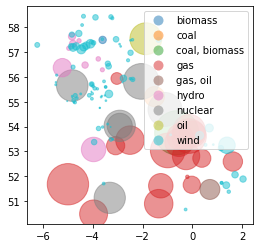

In [14]:
gdf_map = df_to_gdf(df_map)

gdf_map.plot(markersize='output', column='fuel_type', alpha=0.5, legend=True)

In [15]:
#exports
def generate_map_js(gdf, js_template_fp='templates/map.js', js_docs_fp='docs/js/map.js'):
    geojson = json.loads(gdf.to_json())

    rendered_map_js = Template(open(js_template_fp).read()).render(
        zoom=5,
        center=[53.96, -3.22],
        geojson_features=str(geojson).replace('None', 'null')
    )

    with open(js_docs_fp, 'w', encoding='utf8') as fp:
        fp.write(rendered_map_js)
        
    return

In [16]:
generate_map_js(gdf_map, js_template_fp='../templates/map.js', js_docs_fp='../docs/js/map.js')

In [17]:
#exports
def generate_map_md(most_recent_available_dt, md_template_fp='templates/map.md', md_docs_fp='docs/map.md'):
    update_date = pd.to_datetime(most_recent_available_dt).strftime('%Y-%m-%d %H:%M')
    rendered_map_md = Template(open(md_template_fp).read()).render({'update_date': update_date})

    with open(md_docs_fp, 'w', encoding='utf8') as fp:
        fp.write(rendered_map_md)
        
    return

In [18]:
generate_map_md(most_recent_available_dt, md_template_fp='../templates/map.md', md_docs_fp='../docs/map.md')

In [19]:
#exports
app = typer.Typer()

<br>

`python -m ElexonDataPortal.dev.mapgen`

In [25]:
#exports
@app.command()
def generate_map(
    api_key: str=None,
    powerdict_url: str='https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/main/data/output/power_stations.csv',
    js_template_fp: str='templates/map.js', 
    js_docs_fp: str='docs/js/map.js', 
    md_template_fp: str='templates/map.md', 
    md_docs_fp: str='docs/map.md'
):
    if api_key is None:
        assert 'BMRS_API_KEY' in os.environ.keys(), 'If the `api_key` is not specified during client initialisation then it must be set to as the environment variable `BMRS_API_KEY`'
        api_key = os.environ['BMRS_API_KEY']
            
    df_PN = get_latest_PN_df(api_key)

    nearest_half_hour = (pd.Timestamp.now().tz_localize('Europe/London')+pd.Timedelta(minutes=45)).round('30min')
    most_recent_available_dt = max(df_PN.index[pd.to_datetime(df_PN.index).tz_localize('Europe/London')<=nearest_half_hour])
    s_PN = df_PN.loc[most_recent_available_dt]

    df_powerdict = pd.read_csv(powerdict_url)

    osuked_id_mappings = construct_osuked_id_mappings(df_powerdict)
    osuked_id_to_bmu_ids, osuked_id_to_fuel_type, osuked_id_to_name, osuked_id_to_lat_lon = osuked_id_mappings.values()

    df_map = construct_map_df(s_PN, most_recent_available_dt, osuked_id_to_bmu_ids, osuked_id_to_lat_lon, osuked_id_to_fuel_type, osuked_id_to_name)
    gdf_map = df_to_gdf(df_map)

    generate_map_js(gdf_map, js_template_fp=js_template_fp, js_docs_fp=js_docs_fp)
    generate_map_md(most_recent_available_dt, md_template_fp=md_template_fp, md_docs_fp=md_docs_fp)
    
    return 

In [ ]:
generate_map(
    api_key=api_key,
    js_template_fp='../templates/map.js', 
    js_docs_fp='../docs/js/map.js', 
    md_template_fp='../templates/map.md', 
    md_docs_fp='../docs/map.md'
)

0it [00:00, ?it/s]

In [ ]:
#exports
if __name__ == '__main__' and '__file__' in globals():
    app()

In [24]:
#hide
utils.notebook2script('09-map-gen.ipynb')

Converted 09-map-gen.ipynb.
